In [17]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
train_path="/content/drive/MyDrive/dataset/train"
validation_path="/content/drive/MyDrive/dataset/validation"
test_path="/content/drive/MyDrive/dataset/test"

In [52]:
train_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=32)
validation_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(validation_path, target_size=(224,224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 350 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [53]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               weights= 'imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.summary()

In [54]:
for layers in model.layers[:-5]:
  layers.trainable=False

In [ ]:
model.summary()

In [55]:
epochs = 10
optimizer=Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_batches, validation_data=validation_batches, epochs=epochs)

Epoch 1/10
11/11 [==============================] - 19s 2s/step - loss: 1.3695 - accuracy: 0.4971 - val_loss: 0.9825 - val_accuracy: 0.8900
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.7330 - accuracy: 0.9371 - val_loss: 0.5183 - val_accuracy: 0.9500
Epoch 3/10
11/11 [==============================] - 14s 1s/step - loss: 0.3481 - accuracy: 0.9857 - val_loss: 0.2715 - val_accuracy: 0.9800
Epoch 4/10
11/11 [==============================] - 14s 1s/step - loss: 0.1631 - accuracy: 0.9971 - val_loss: 0.1608 - val_accuracy: 0.9900
Epoch 5/10
11/11 [==============================] - 14s 1s/step - loss: 0.0858 - accuracy: 0.9971 - val_loss: 0.1173 - val_accuracy: 0.9900
Epoch 6/10
11/11 [==============================] - 14s 1s/step - loss: 0.0548 - accuracy: 1.0000 - val_loss: 0.1013 - val_accuracy: 0.9900
Epoch 7/10
11/11 [==============================] - 15s 1s/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.0865 - val_accuracy: 0.9900
Epoch 8/10
11/11 [==

In [56]:
test_labels = test_batches.classes
preds = model.predict(test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=preds.argmax(axis=1))
test_batches.class_indices

{'chinesemoneyplant': 0,
 'dragontree': 1,
 'orchid': 2,
 'rubberplant': 3,
 'snakeplant': 4}

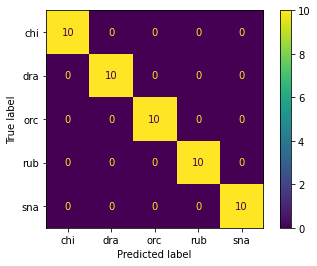

In [57]:
cm_plot_labels = ['chi', 'dra', 'orc', 'rub', 'sna']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()